# Advanced Models for Fraud Detection

In this notebook, we will explore advanced machine learning models to improve our fraud detection capabilities. We will evaluate models such as Random Forest and XGBoost, and compare their performance against our baseline logistic regression model.

🚀 PHASE 4 : MODÈLES AVANCÉS - Random Forest & XGBoost

[0] Chargement des données et du scaler...
✓ Données chargées : 24000 train, 6000 val
✓ Taux de fraude train : 1.98%
✓ Taux de fraude val   : 1.98%

📊 F1-Score Baseline (Logistic Regression) : 0.1889

[4.1] Application de SMOTE pour gérer le déséquilibre des classes

📊 Avant SMOTE :
   - Classe 0 (légitime) : 23,524 (98.02%)
   - Classe 1 (fraude)   : 476 (1.98%)
   - Ratio déséquilibre  : 1:50

⚙️  Application de SMOTE...
✓ SMOTE appliqué en 0.02 secondes

📊 Après SMOTE :
   - Classe 0 (légitime) : 23,524 (50.00%)
   - Classe 1 (fraude)   : 23,524 (50.00%)
   - Ratio équilibré     : 1:1 ✓

💾 Données rééquilibrées : 47,048 samples

[4.2] Entraînement Random Forest sur données SMOTE

⚙️  Entraînement Random Forest...
   - Paramètres : n_estimators=100, max_depth=15
✓ Modèle entraîné en 3.26 secondes

🎯 RÉSULTATS RANDOM FOREST :
Métrique                  Score     vs Baseline
----------------------------------------------------------

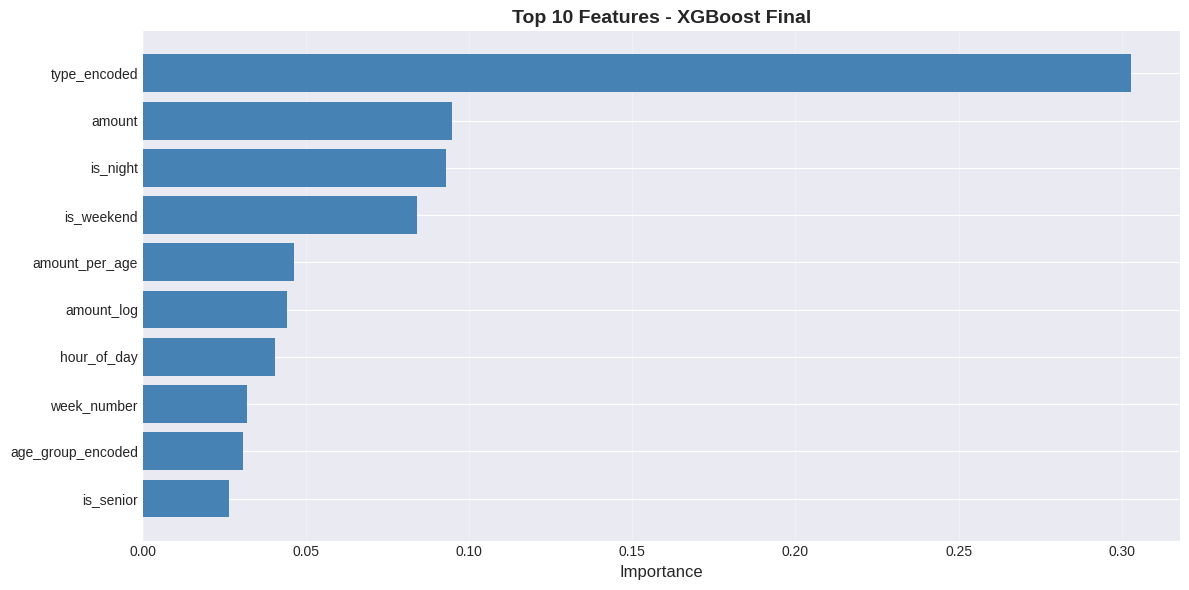

✓ Importance sauvegardée : ../models/feature_importance.csv

[4.6] Comparaison Finale des Modèles

📊 TABLEAU RÉCAPITULATIF :
                        Modèle  F1-Score  Precision   Recall  ROC-AUC  Temps (s)
Logistic Regression (Baseline)  0.188879   0.105523 0.899160 0.934475   1.394450
         Random Forest + SMOTE  0.557994   0.445000 0.747899 0.957964   3.259278
                XGBoost (base)  0.707792   0.576720 0.915966 0.972424   8.535102
             XGBoost (tuned) ⭐  0.785714   0.744361 0.831933 0.971471  10.204365

✓ Comparaison sauvegardée : ../models/models_comparison.csv

🏆 MEILLEUR MODÈLE SÉLECTIONNÉ : XGBoost (tuned) ⭐
   - F1-Score : 0.7857
   - Gain vs Baseline : +0.5968 (316.0%)

📊 Génération de visualisations comparatives...
✓ Visualisation sauvegardée : ../visualizations/models_comparison.png


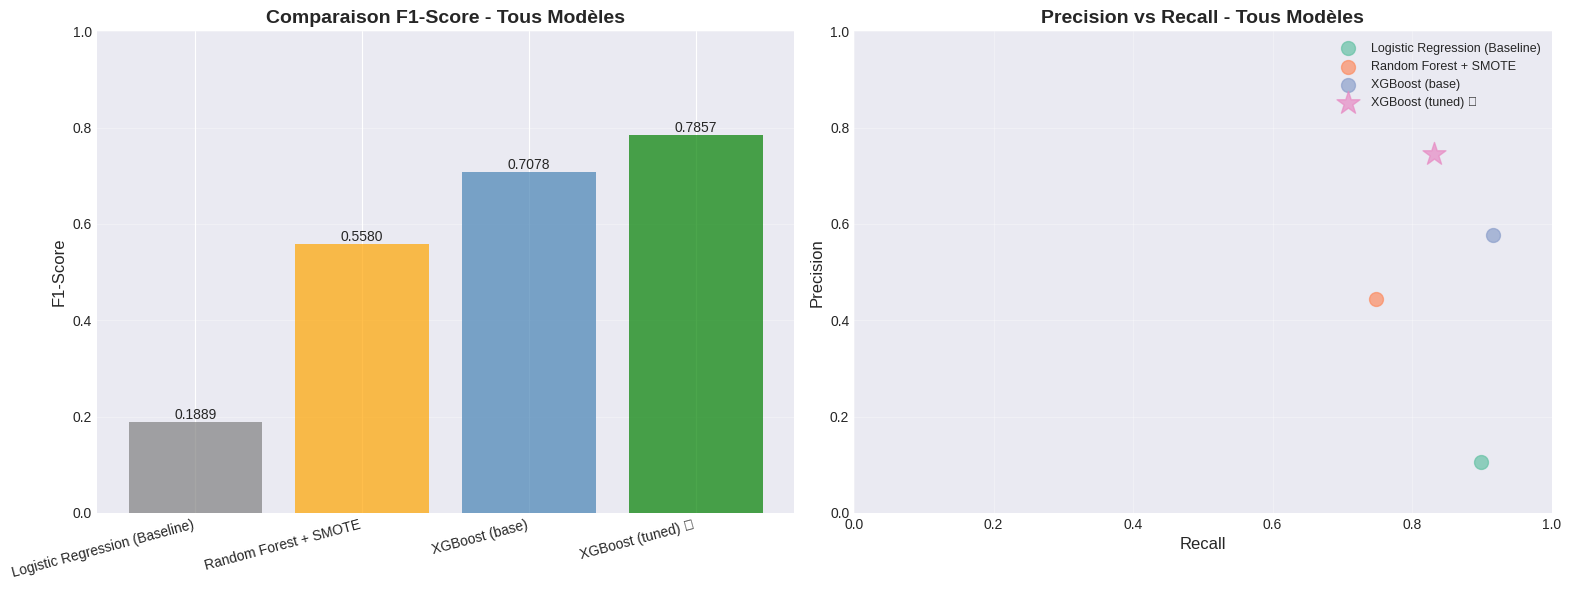


✅ PHASE 4 TERMINÉE - MODÈLES AVANCÉS

📈 PROGRESSION DES PERFORMANCES :
   1. Baseline (Logistic)     : F1 = 0.1889
   2. Random Forest + SMOTE   : F1 = 0.5580 (+0.3691)
   3. XGBoost (base)          : F1 = 0.7078 (+0.5189)
   4. XGBoost (tuned) ⭐      : F1 = 0.7857 (+0.5968)

📂 FICHIERS GÉNÉRÉS :
   - ../models/random_forest.pkl
   - ../models/xgboost_base.pkl
   - ../models/xgboost_final.pkl ⭐
   - ../models/feature_importance.csv
   - ../models/models_comparison.csv
   - ../visualizations/feature_importance.png
   - ../visualizations/models_comparison.png

🎯 PROCHAINE ÉTAPE : PHASE 5 - Génération submission.csv


In [5]:
# ========================================
# PHASE 4 : MODÈLES AVANCÉS
# Durée estimée : 90 minutes (13h00 - 14h30)
# Objectif : Améliorer le F1-Score baseline avec RF et XGBoost
# ========================================

# Import des librairies
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, classification_report, confusion_matrix
)
import joblib

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

print("="*70)
print("🚀 PHASE 4 : MODÈLES AVANCÉS - Random Forest & XGBoost")
print("="*70)

# ========================================
# CHARGEMENT DES DONNÉES (Phase 3)
# ========================================
print("\n[0] Chargement des données et du scaler...")

# Charger les données d'entraînement
train_data = pd.read_csv('../data/processed/train_engineered.csv')

# Séparer features et target
X = train_data.drop('is_fraud', axis=1)
y = train_data['is_fraud']

# Charger le split et le scaler de la Phase 3
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Charger le scaler (sauvegardé en Phase 3)
scaler = joblib.load('../models/scaler.pkl')
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"✓ Données chargées : {X_train.shape[0]} train, {X_val.shape[0]} val")
print(f"✓ Taux de fraude train : {y_train.mean()*100:.2f}%")
print(f"✓ Taux de fraude val   : {y_val.mean()*100:.2f}%")

# Charger les métriques baseline
baseline_metrics = pd.read_csv('../models/baseline_metrics.csv')
baseline_f1 = baseline_metrics['f1_score'].values[0]
print(f"\n📊 F1-Score Baseline (Logistic Regression) : {baseline_f1:.4f}")

# ========================================
# TÂCHE 4.1 : GESTION DU DÉSÉQUILIBRE (15 min)
# ========================================
print("\n" + "="*70)
print("[4.1] Application de SMOTE pour gérer le déséquilibre des classes")
print("="*70)

# Calculer le déséquilibre initial
fraud_ratio_before = y_train.mean()
print(f"\n📊 Avant SMOTE :")
print(f"   - Classe 0 (légitime) : {(y_train==0).sum():,} ({(y_train==0).mean()*100:.2f}%)")
print(f"   - Classe 1 (fraude)   : {(y_train==1).sum():,} ({(y_train==1).mean()*100:.2f}%)")
print(f"   - Ratio déséquilibre  : 1:{int(1/fraud_ratio_before)}")

# Appliquer SMOTE
print("\n⚙️  Application de SMOTE...")
start_time = time.time()

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

smote_time = time.time() - start_time

print(f"✓ SMOTE appliqué en {smote_time:.2f} secondes")

# Vérifier la nouvelle distribution
print(f"\n📊 Après SMOTE :")
print(f"   - Classe 0 (légitime) : {(y_train_resampled==0).sum():,} ({(y_train_resampled==0).mean()*100:.2f}%)")
print(f"   - Classe 1 (fraude)   : {(y_train_resampled==1).sum():,} ({(y_train_resampled==1).mean()*100:.2f}%)")
print(f"   - Ratio équilibré     : 1:1 ✓")

# Sauvegarder les données rééquilibrées (optionnel)
print(f"\n💾 Données rééquilibrées : {X_train_resampled.shape[0]:,} samples")

# ========================================
# TÂCHE 4.2 : RANDOM FOREST (20 min)
# ========================================
print("\n" + "="*70)
print("[4.2] Entraînement Random Forest sur données SMOTE")
print("="*70)

# Initialiser le modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,      # Nombre d'arbres
    max_depth=15,          # Profondeur maximale
    min_samples_split=5,   # Minimum de samples pour split
    min_samples_leaf=2,    # Minimum de samples par feuille
    random_state=42,
    n_jobs=-1,             # Parallélisation
    class_weight='balanced' # Sécurité supplémentaire
)

print("\n⚙️  Entraînement Random Forest...")
print(f"   - Paramètres : n_estimators=100, max_depth=15")

# Entraîner sur données SMOTE
start_time = time.time()
rf_model.fit(X_train_resampled, y_train_resampled)
rf_train_time = time.time() - start_time

print(f"✓ Modèle entraîné en {rf_train_time:.2f} secondes")

# Prédictions sur validation (SANS SMOTE - données originales)
y_pred_rf = rf_model.predict(X_val_scaled)
y_proba_rf = rf_model.predict_proba(X_val_scaled)[:, 1]

# Calcul des métriques
rf_f1 = f1_score(y_val, y_pred_rf)
rf_precision = precision_score(y_val, y_pred_rf)
rf_recall = recall_score(y_val, y_pred_rf)
rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_roc_auc = roc_auc_score(y_val, y_proba_rf)

# Affichage des résultats
print(f"\n🎯 RÉSULTATS RANDOM FOREST :")
print(f"{'='*70}")
print(f"{'Métrique':<20} {'Score':>10} {'vs Baseline':>15}")
print(f"{'-'*70}")
print(f"{'F1-Score':<20} {rf_f1:>10.4f} {f'+{(rf_f1-baseline_f1):.4f}' if rf_f1>baseline_f1 else f'{(rf_f1-baseline_f1):.4f}':>15}")
print(f"{'Precision':<20} {rf_precision:>10.4f}")
print(f"{'Recall':<20} {rf_recall:>10.4f}")
print(f"{'ROC-AUC':<20} {rf_roc_auc:>10.4f}")
print(f"{'Temps entraînement':<20} {rf_train_time:>10.2f}s")
print(f"{'='*70}")

# Sauvegarder le modèle
joblib.dump(rf_model, '../models/random_forest.pkl')
print("✓ Modèle sauvegardé : ../models/random_forest.pkl")

# ========================================
# TÂCHE 4.3 : XGBOOST (sans tuning) (15 min)
# ========================================
print("\n" + "="*70)
print("[4.3] Entraînement XGBoost avec scale_pos_weight")
print("="*70)

# Calculer scale_pos_weight (ratio classes déséquilibrées)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n📊 Calcul scale_pos_weight : {scale_pos_weight:.2f}")
print(f"   (Ratio légitime/fraude pour compenser le déséquilibre)")

# Initialiser XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # ⭐ CLEF pour déséquilibre
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("\n⚙️  Entraînement XGBoost...")
print(f"   - Paramètres : n_estimators=100, max_depth=6, scale_pos_weight={scale_pos_weight:.2f}")

# Entraîner sur données ORIGINALES (XGBoost gère bien avec scale_pos_weight)
start_time = time.time()
xgb_model.fit(X_train_scaled, y_train)
xgb_train_time = time.time() - start_time

print(f"✓ Modèle entraîné en {xgb_train_time:.2f} secondes")

# Prédictions
y_pred_xgb = xgb_model.predict(X_val_scaled)
y_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Métriques
xgb_f1 = f1_score(y_val, y_pred_xgb)
xgb_precision = precision_score(y_val, y_pred_xgb)
xgb_recall = recall_score(y_val, y_pred_xgb)
xgb_accuracy = accuracy_score(y_val, y_pred_xgb)
xgb_roc_auc = roc_auc_score(y_val, y_proba_xgb)

# Affichage
print(f"\n🎯 RÉSULTATS XGBOOST (sans tuning) :")
print(f"{'='*70}")
print(f"{'Métrique':<20} {'Score':>10} {'vs Baseline':>15} {'vs RF':>15}")
print(f"{'-'*70}")
print(f"{'F1-Score':<20} {xgb_f1:>10.4f} {f'+{(xgb_f1-baseline_f1):.4f}':>15} {f'+{(xgb_f1-rf_f1):.4f}' if xgb_f1>rf_f1 else f'{(xgb_f1-rf_f1):.4f}':>15}")
print(f"{'Precision':<20} {xgb_precision:>10.4f}")
print(f"{'Recall':<20} {xgb_recall:>10.4f}")
print(f"{'ROC-AUC':<20} {xgb_roc_auc:>10.4f}")
print(f"{'Temps entraînement':<20} {xgb_train_time:>10.2f}s")
print(f"{'='*70}")

# Sauvegarder
joblib.dump(xgb_model, '../models/xgboost_base.pkl')
print("✓ Modèle sauvegardé : ../models/xgboost_base.pkl")

# ========================================
# TÂCHE 4.4 : HYPERPARAMETER TUNING (25 min)
# ========================================
print("\n" + "="*70)
print("[4.4] Hyperparameter Tuning Manuel - XGBoost")
print("="*70)

# Définir les combinaisons à tester (3-5 max pour gagner du temps)
param_grid = [
    {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200},
    {'learning_rate': 0.1,  'max_depth': 6, 'n_estimators': 200},
    {'learning_rate': 0.1,  'max_depth': 8, 'n_estimators': 200},
    {'learning_rate': 0.1,  'max_depth': 4, 'n_estimators': 300},
    {'learning_rate': 0.3,  'max_depth': 6, 'n_estimators': 100},
]

print(f"\n🔍 Test de {len(param_grid)} combinaisons de paramètres...")

best_f1 = 0
best_params = None
best_model = None
results = []

for i, params in enumerate(param_grid, 1):
    print(f"\n[{i}/{len(param_grid)}] Test : lr={params['learning_rate']}, depth={params['max_depth']}, n_est={params['n_estimators']}")
    
    # Créer et entraîner le modèle
    model = XGBClassifier(
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    start = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start
    
    # Évaluer
    y_pred = model.predict(X_val_scaled)
    f1 = f1_score(y_val, y_pred)
    
    print(f"   → F1-Score : {f1:.4f} (temps : {train_time:.2f}s)")
    
    # Sauvegarder les résultats
    results.append({
        'learning_rate': params['learning_rate'],
        'max_depth': params['max_depth'],
        'n_estimators': params['n_estimators'],
        'f1_score': f1,
        'train_time': train_time
    })
    
    # Mettre à jour le meilleur modèle
    if f1 > best_f1:
        best_f1 = f1
        best_params = params
        best_model = model
        print(f"   ⭐ NOUVEAU MEILLEUR F1-Score : {best_f1:.4f}")

# Afficher les résultats
results_df = pd.DataFrame(results).sort_values('f1_score', ascending=False)
print(f"\n📊 RÉSULTATS DU TUNING :")
print(results_df.to_string(index=False))

print(f"\n🏆 MEILLEURS PARAMÈTRES :")
print(f"   - learning_rate  : {best_params['learning_rate']}")
print(f"   - max_depth      : {best_params['max_depth']}")
print(f"   - n_estimators   : {best_params['n_estimators']}")
print(f"   - F1-Score       : {best_f1:.4f}")
print(f"   - Gain vs baseline : +{(best_f1 - baseline_f1):.4f}")

# Sauvegarder le meilleur modèle
joblib.dump(best_model, '../models/xgboost_final.pkl')
print("\n✓ Meilleur modèle sauvegardé : ../models/xgboost_final.pkl")

# Métriques complètes du meilleur modèle
y_pred_best = best_model.predict(X_val_scaled)
y_proba_best = best_model.predict_proba(X_val_scaled)[:, 1]

best_precision = precision_score(y_val, y_pred_best)
best_recall = recall_score(y_val, y_pred_best)
best_roc_auc = roc_auc_score(y_val, y_proba_best)

# ========================================
# TÂCHE 4.5 : FEATURE IMPORTANCE (10 min)
# ========================================
print("\n" + "="*70)
print("[4.5] Analyse de l'importance des features")
print("="*70)

# Extraire les importances
feature_importance = best_model.feature_importances_
feature_names = X_train.columns

# Créer un DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n🔝 TOP 10 FEATURES LES PLUS IMPORTANTES :")
print(importance_df.head(10).to_string(index=False))

# Visualisation
plt.figure(figsize=(12, 6))
top_features = importance_df.head(10)

plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance', fontsize=12)
plt.title('Top 10 Features - XGBoost Final', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.savefig('../visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✓ Graphique sauvegardé : ../visualizations/feature_importance.png")
plt.show()

# Sauvegarder le DataFrame
importance_df.to_csv('../models/feature_importance.csv', index=False)
print("✓ Importance sauvegardée : ../models/feature_importance.csv")

# ========================================
# TÂCHE 4.6 : COMPARAISON DES MODÈLES (5 min)
# ========================================
print("\n" + "="*70)
print("[4.6] Comparaison Finale des Modèles")
print("="*70)

# Créer le tableau de comparaison
comparison_data = {
    'Modèle': [
        'Logistic Regression (Baseline)',
        'Random Forest + SMOTE',
        'XGBoost (base)',
        'XGBoost (tuned) ⭐'
    ],
    'F1-Score': [
        baseline_f1,
        rf_f1,
        xgb_f1,
        best_f1
    ],
    'Precision': [
        baseline_metrics['precision'].values[0],
        rf_precision,
        xgb_precision,
        best_precision
    ],
    'Recall': [
        baseline_metrics['recall'].values[0],
        rf_recall,
        xgb_recall,
        best_recall
    ],
    'ROC-AUC': [
        baseline_metrics['roc_auc'].values[0],
        rf_roc_auc,
        xgb_roc_auc,
        best_roc_auc
    ],
    'Temps (s)': [
        baseline_metrics['training_time_sec'].values[0],
        rf_train_time,
        xgb_train_time,
        results_df.iloc[0]['train_time']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 TABLEAU RÉCAPITULATIF :")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Sauvegarder la comparaison
comparison_df.to_csv('../models/models_comparison.csv', index=False)
print("\n✓ Comparaison sauvegardée : ../models/models_comparison.csv")

# Sélectionner le meilleur modèle
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Modèle']
best_model_f1 = comparison_df['F1-Score'].max()

print(f"\n🏆 MEILLEUR MODÈLE SÉLECTIONNÉ : {best_model_name}")
print(f"   - F1-Score : {best_model_f1:.4f}")
print(f"   - Gain vs Baseline : +{(best_model_f1 - baseline_f1):.4f} ({((best_model_f1/baseline_f1 - 1)*100):.1f}%)")

# ========================================
# VISUALISATION COMPARATIVE (Bonus)
# ========================================
print("\n📊 Génération de visualisations comparatives...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : F1-Score par modèle
ax1 = axes[0]
bars = ax1.bar(range(len(comparison_df)), comparison_df['F1-Score'], 
               color=['gray', 'orange', 'steelblue', 'green'], alpha=0.7)
ax1.set_xticks(range(len(comparison_df)))
ax1.set_xticklabels(comparison_df['Modèle'], rotation=15, ha='right')
ax1.set_ylabel('F1-Score', fontsize=12)
ax1.set_title('Comparaison F1-Score - Tous Modèles', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# Graphique 2 : Precision vs Recall
ax2 = axes[1]
for i, row in comparison_df.iterrows():
    marker = 'o' if i < 3 else '*'
    size = 100 if i < 3 else 300
    ax2.scatter(row['Recall'], row['Precision'], s=size, marker=marker, alpha=0.7,
                label=row['Modèle'])

ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision vs Recall - Tous Modèles', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../visualizations/models_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualisation sauvegardée : ../visualizations/models_comparison.png")
plt.show()

# ========================================
# RÉSUMÉ FINAL
# ========================================
print("\n" + "="*70)
print("✅ PHASE 4 TERMINÉE - MODÈLES AVANCÉS")
print("="*70)

print(f"\n📈 PROGRESSION DES PERFORMANCES :")
print(f"   1. Baseline (Logistic)     : F1 = {baseline_f1:.4f}")
print(f"   2. Random Forest + SMOTE   : F1 = {rf_f1:.4f} (+{(rf_f1-baseline_f1):.4f})")
print(f"   3. XGBoost (base)          : F1 = {xgb_f1:.4f} (+{(xgb_f1-baseline_f1):.4f})")
print(f"   4. XGBoost (tuned) ⭐      : F1 = {best_f1:.4f} (+{(best_f1-baseline_f1):.4f})")

print(f"\n📂 FICHIERS GÉNÉRÉS :")
print(f"   - ../models/random_forest.pkl")
print(f"   - ../models/xgboost_base.pkl")
print(f"   - ../models/xgboost_final.pkl ⭐")
print(f"   - ../models/feature_importance.csv")
print(f"   - ../models/models_comparison.csv")
print(f"   - ../visualizations/feature_importance.png")
print(f"   - ../visualizations/models_comparison.png")

print(f"\n🎯 PROCHAINE ÉTAPE : PHASE 5 - Génération submission.csv")
print("="*70)